# Using Reddit's API for Predicting Comments

# Executive Summary

Love books?  Want to chat about them on Reddit?  Well, you're in luck -- there are numerous book related subreddits available.  But which one is appropriate?  Can we identify the unique characteristics of a typical post to each of the subreddits and predict which subreddict a particular post came from?  That is the goal of this project.

In this project, we used the reddit api to gather ~1000 posts from each of 7 book-themed subreddits:
* books
* Fantasy
* sciencefiction
* booksuggestions
* whatsthatbook
* bookclub
* YAlit

The following features were gathered or calculated for each post:
* ups: # of votes post has received so far
* downs: # of downvotes post has received sof ar
* num_comments: # of comments made about post
* num_cross posts: # times post has been cross posted on another subreddit
* title length: (calculated field) length of the title
* text length:  (calculated field) length of the text
* external_url: (calculated field) 1 if post contains a url for a domain other than reddit.com, otherwise 0
* hour_of_day: (calculated field) hour of day (24 hour clock) post was made
* *words in title*: TFIDF score for cleaned words in title

The step to generate these features was included in a pipeline to make it easier to consistently apply the same transformations to the validation set and future test sets.  

In order to evaluate the words in the post title, they had to first be cleaned up.  This involved removing digits, punctuation, english stop words and special "giveaway" words (i.e. Fantasy or SciFi). The remaining words were then lemmatized (based on their assigned part of speech tag) and finally tokenized (broken into a list of individual words) and assigned a TFIDF score (this score evaluates the.  

The cleaned vector plus the above fields were then fed to a number of classification models and scored based their accuracy and area under the curve in predicting the subreddit they came from.

Tests were run on unigrams (single words), bigrams and both unigrams and bigrams from the post title.  Using bigrams resulted in decreased accuracy, but the results on unigrams plus bigrams were fairly equivalent.  The final model used both.  Including unigrams from the post text worsened accuracy and the text was not included in the final model.

A number of different classification models were used: Logistic Regression, Support Vector Classifer, Naive Bayes, Random Forst and CatBooost.  Interestingly, a basic Logistic Regression worked as well or better than a more sophisticated CatBoost model.  Each of those models, however, used very different features to classify the posts.  Logistic Regression relied heavily on words in the post title, while CatBoost used some of the calculated fields, such as external_url, ups, text_len, num_comments and title_len before relying on title words




# Project Start

## Goal: What characteristics of a post on Reddit contribute most to what subreddit it belongs to?

### Import libraries

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import time
from datetime import datetime
import re

import pickle

import nltk
nltk.download('stopwords')  # run once
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import string

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

#import sklearn
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error,
    f1_score,recall_score,precision_score
)


from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
# from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestClassifier
)

from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, Imputer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder
)

from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, SelectPercentile, 
    SelectFromModel, f_regression, RFECV
)

from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.model_selection import GridSearchCV

from sklearn.base import TransformerMixin, BaseEstimator

#from utils import separation_plot
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


import catboost as cb
from catboost import CatBoostClassifier, Pool

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blahjays\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Settings / Instructions for running this project

* set get_fresh_data to True to retrieve fresh posts from Reddit.  otherwise, it will load the csv of previously retrieved posts defined in saved_data

* set rerun_grid_searches to True to rerun  GridSearchCV on all classification models (warning: this can take a long time).  IF this is left as false, models will be generated based on the best model parameters found by GridSearchCV

In [2]:
verbose = False # controls whether debug print statements are executed or not
get_fresh_data = False # if false, read from csv instead
rerun_grid_searches=False

#saved_data = "Data/Raw/reddit_posts1541261441.0.csv" #file to read if not getting fresh data
saved_data = "Data/Final/reddit_posts_train.csv"
all_posts = []

headers = {'User-Agent': 'nlp tester (by /u/schweitz_gallusplatz)'}
URLs = ["books","Fantasy","sciencefiction","booksuggestions","whatsthatbook", "bookclub","YAlit"]
subreddit_mapping ={'books': 0, 'Fantasy': 1, 'sciencefiction': 2,'booksuggestions': 3, 'whatsthatbook':4, "bookclub": 5, "YAlit":6}

### Scrape Thread Info from Reddit.com
* if getting fresh data, loop through all the definied subreddit urls and load the posts
* if not getting fresh data, open the specified csv file
* keeping looping until we don't get any more posts (we want as much data as possible)

In [3]:
def fetch_page(url, after=''):
    params = {'after': after}
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()['data']['children']
    else:
        print(f"Error connecting: status code {response.status_code}")

In [4]:
def parse_post(post):
    keep = ['subreddit', 'title', 'selftext', 'downs', 'ups', 'num_comments', 'name', 'author','created_utc','url', 'num_crossposts'] 
    return {k:v for k, v in post['data'].items() if k in keep}


In [5]:
def parse_page(page):
    after = ''
    posts = []
    for post in page:
        post = parse_post(post)
        after = post['name']
        posts.append(post)
    return posts, after

In [6]:
def fetch_subreddit(subreddit, pages=40, only_recent=False):
    ''' 
    only_recent: if true, will retrieve the 10 most recent mosts for the given subreddit
    '''
    url = f'https://www.reddit.com/r/{subreddit}.json'
    if only_recent:
        url=f'https://www.reddit.com/r/{subreddit}/new.json?sort=new&limit=10'
    after = ''
   
    for i in range(pages):
        print(f'Fetching Page {i + 1}')
        page = fetch_page(url, after)
        posts, after = parse_page(page)
        all_posts.extend(posts)
        time.sleep(5)
    return all_posts

In [7]:
all_posts = []
if get_fresh_data:
    for url in URLs:
        posts = fetch_subreddit(url)
        posts_df=pd.DataFrame(posts)
        #append epoch timestamp so we don't overwrite earlier results
        posts_df.to_csv('Data/Raw/reddit_posts' + str(round(time.time(),0)) + '.csv', index=False)
else:
    print("reading saved data from csv...")
    posts_df =  pd.read_csv(saved_data)

reading saved data from csv...


In [8]:
posts_df.head()
posts_df[['created_utc', 'downs', 'num_comments',
       'num_crossposts', 'subreddit', 'title', 'ups', 'url', 'selftext']].head()

,created_utc,downs,num_comments,num_crossposts,subreddit,title,ups,url,selftext
0,1.541015e+09,0,10,0,books,The /r/books book club selection for November ...,29,https://www.reddit.com/r/books/comments/9t24ml...,From [Goodreads](https://www.goodreads.com/boo...
1,1.541174e+09,0,55,0,books,I’m Caroline Spector creator of the Amazing Bu...,9,https://www.reddit.com/r/books/comments/9tlc2h...,Caroline Spector has been an editor and writer...
2,1.541169e+09,0,164,0,books,Growing Up Surrounded by Books Has a Lasting P...,3672,http://www.openculture.com/2018/11/growing-sur...,NaN
3,1.541089e+09,0,459,2,books,Restricting Books for Prisoners Harms Everyone...,18063,https://electricliterature.com/restricting-boo...,NaN
4,1.541168e+09,0,1,0,books,The Soviet Children's Books That Broke the Rul...,28,https://www.atlasobscura.com/articles/soviet-c...,NaN


### Check our data

* The count fields are all heavily right skewed.  For example, one post attracted 5802 comments, while the median number is only 6 

#### Meaning of gathered info
* Title: Title of the post
* selftext: Text of the post (if any -- some posts contain only a url and no text)
* subreddit: the subreddit the post came from
* author: reddit id of the poster
* created: date/timestamp of when post was created; unix time stamp
* num_comments: number of comments on the post
* url - some posts do not contain any text, but do contain a url(i.e. the news was posted on bbc.com).  see this post as an example: https://www.reddit.com/r/books/comments/9sxmtu/jin_yong_the_tolkien_of_chinese_literature_dies/
* num_crossposts: # times post has been crossposted on other subreddits
* ups: # times post has been upvoted
* downs: # times post has been downvoted



In [9]:
posts_df.describe()

,created_utc,downs,num_comments,num_crossposts,ups
count,6.934000e+03,6934.0,6934.000000,6934.000000,6934.000000
mean,1.528174e+09,0.0,20.396452,0.039371,83.950534
std,2.141121e+07,0.0,125.279287,0.487290,941.815708
min,1.430015e+09,0.0,0.000000,0.000000,0.000000
25%,1.530264e+09,0.0,2.000000,0.000000,3.000000
50%,1.539210e+09,0.0,6.000000,0.000000,7.000000
75%,1.540314e+09,0.0,16.000000,0.000000,16.000000
max,1.541259e+09,0.0,5798.000000,25.000000,38170.000000


In [10]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6934 entries, 0 to 6933
Data columns (total 11 columns):
author            6934 non-null object
created_utc       6934 non-null float64
downs             6934 non-null int64
name              6934 non-null object
num_comments      6934 non-null int64
num_crossposts    6934 non-null int64
selftext          5501 non-null object
subreddit         6934 non-null object
title             6934 non-null object
ups               6934 non-null int64
url               6934 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 596.0+ KB


In [11]:
posts_df.isna().sum()

author               0
created_utc          0
downs                0
name                 0
num_comments         0
num_crossposts       0
selftext          1433
subreddit            0
title                0
ups                  0
url                  0
dtype: int64

In [12]:
posts_df['subreddit'].value_counts()


booksuggestions    1002
sciencefiction      997
bookclub            994
whatsthatbook       992
YAlit               992
Fantasy             987
books               970
Name: subreddit, dtype: int64

#### Notes:
* no missing values, except in selftext (often empty if post references an external url)
* data types look ok
* fairly balanced classes

### Add a numeric SubRedditID column since most models require numeric values for classification

In [13]:
# con
posts_df['subreddit_id'] = posts_df['subreddit'].map(subreddit_mapping).astype(int)
posts_df['subreddit_id'].value_counts()

3    1002
2     997
5     994
6     992
4     992
1     987
0     970
Name: subreddit_id, dtype: int64

## EDA

In [14]:
posts_df.groupby(by='subreddit').mean()

,created_utc,downs,num_comments,num_crossposts,ups,subreddit_id
subreddit,,,,,,
Fantasy,1.539955e+09,0.0,29.494428,0.040527,52.360689,1
YAlit,1.500317e+09,0.0,15.217742,0.000000,10.674395,6
bookclub,1.501573e+09,0.0,8.667002,0.002012,14.637827,5
books,1.540485e+09,0.0,66.674227,0.191753,471.061856,0
booksuggestions,1.539436e+09,0.0,10.348303,0.009980,9.694611,3
sciencefiction,1.535577e+09,0.0,10.803410,0.032096,34.441324,2
whatsthatbook,1.540113e+09,0.0,2.815524,0.003024,4.346774,4


In [15]:
posts_df.groupby(by='subreddit').median()

,created_utc,downs,num_comments,num_crossposts,ups,subreddit_id
subreddit,,,,,,
Fantasy,1.539902e+09,0,14,0,12,1
YAlit,1.498687e+09,0,10,0,8,6
bookclub,1.503844e+09,0,5,0,12,5
books,1.540483e+09,0,14,0,12,0
booksuggestions,1.539562e+09,0,6,0,3,3
sciencefiction,1.535565e+09,0,3,0,4,2
whatsthatbook,1.540103e+09,0,2,0,3,4


* Science Fiction thread seems to have fewer up votes and comments than the other two threads

Text(0,0.5,'# of Up Votes')

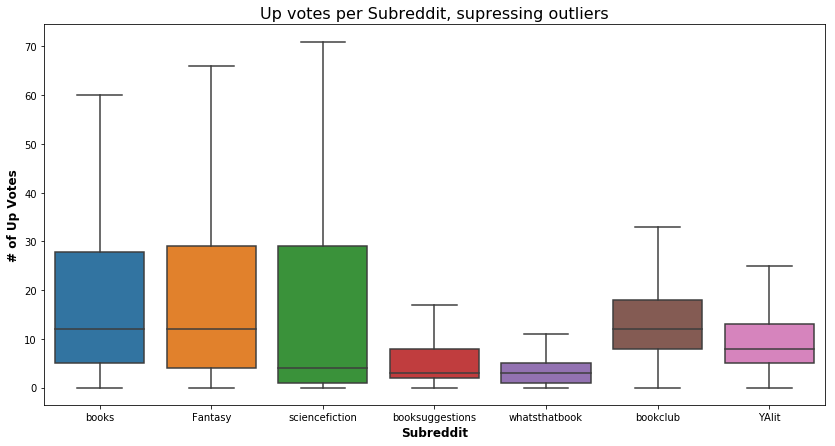

In [16]:
fig, ax = plt.subplots(figsize=(14,7))
ax=sns.boxplot(x="subreddit", y="ups", data=posts_df,showfliers=False, order=URLs)
plt.title("Up votes per Subreddit, supressing outliers", fontsize=16)
plt.xlabel("Subreddit", fontsize=12, fontweight='bold')
plt.ylabel("# of Up Votes", fontsize=12, fontweight='bold')

Text(0,0.5,'# of Comments')

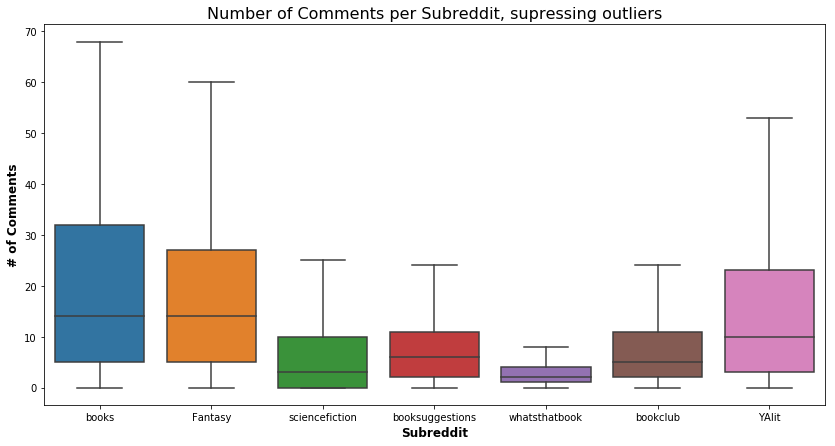

In [17]:
fig, ax = plt.subplots(figsize=(14,7))
ax=sns.boxplot(x="subreddit", y="num_comments", data=posts_df,showfliers=False, order=URLs)
plt.title("Number of Comments per Subreddit, supressing outliers", fontsize=16)
plt.xlabel("Subreddit", fontsize=12, fontweight='bold')
plt.ylabel("# of Comments", fontsize=12, fontweight='bold')

In [18]:
df_postlen = (posts_df.groupby('subreddit')['selftext']
                            .apply(lambda x: np.mean(x.str.len()))
                            .reset_index(name='avg_post_len'))
df_postlen

,subreddit,avg_post_len
0,Fantasy,1480.309735
1,YAlit,588.662286
2,bookclub,1551.221998
3,books,1149.751715
4,booksuggestions,358.737201
5,sciencefiction,999.215026
6,whatsthatbook,621.032158


In [19]:
df_title_len = (posts_df.groupby('subreddit')['title']
                            .apply(lambda x: np.mean(x.str.len()))
                            .reset_index(name='avg_title_len'))
df_title_len

,subreddit,avg_title_len
0,Fantasy,57.481256
1,YAlit,54.710685
2,bookclub,45.495976
3,books,65.155670
4,booksuggestions,51.504990
5,sciencefiction,63.335005
6,whatsthatbook,84.739919


Text(0,0.5,'Avg. Title Length')

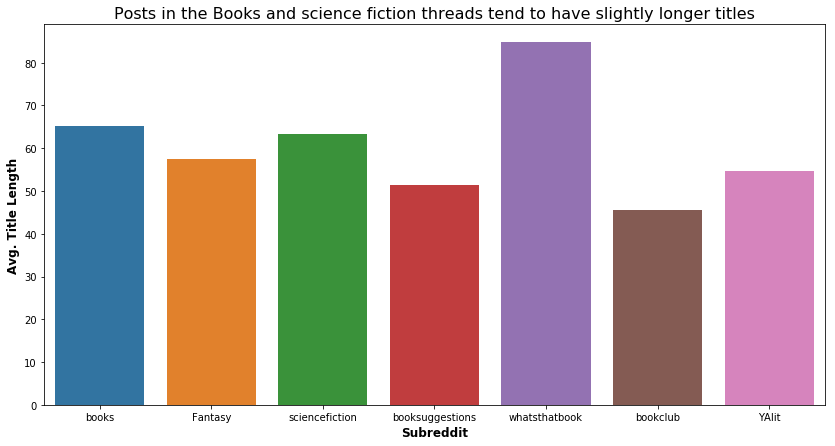

In [20]:
fig, ax = plt.subplots(figsize=(14,7))
ax=sns.barplot(x="subreddit", y="avg_title_len", data=df_title_len, order=URLs)
plt.title("Posts in the Books and science fiction threads tend to have slightly longer titles", fontsize=16)
plt.xlabel("Subreddit", fontsize=12, fontweight='bold')
plt.ylabel("Avg. Title Length", fontsize=12, fontweight='bold')

In [21]:
df_url_len = (posts_df.groupby('subreddit')['url']
                            .apply(lambda x: np.mean(x.str.len()))
                            .reset_index(name='avg_url_len'))
df_url_len

,subreddit,avg_url_len
0,Fantasy,88.627153
1,YAlit,82.685484
2,bookclub,86.616700
3,books,90.861856
4,booksuggestions,95.028942
5,sciencefiction,77.534604
6,whatsthatbook,98.666331


## Train/ Test split

In [22]:
#do train test split first
# shuffle data as it is in order!!
X_train, X_test, y_train, y_test = train_test_split(posts_df, posts_df['subreddit_id'], random_state=42, shuffle=True)
X_train=X_train.drop(columns=['subreddit','subreddit_id'], axis=1)
X_test=X_test.drop(columns=['subreddit','subreddit_id'], axis=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train.head()


,author,created_utc,downs,name,num_comments,num_crossposts,selftext,title,ups,url
6782,pikameta,1.471131e+09,0,t3_4xllxt,23,0,"Hey guys, we are looking for some new books fo...","Recs for 14 yr old boy. Standalone, Male prota...",2,https://www.reddit.com/r/YAlit/comments/4xllxt...
4870,argonaut30,1.539176e+09,0,t3_9mz4d7,3,0,It's been a couple years I've been Googling an...,Four book middle grade fantasy series I've bee...,1,https://www.reddit.com/r/whatsthatbook/comment...
6027,nymeria1031,1.535504e+09,0,t3_9b4n3o,43,0,I'm at a loss of what to read right now and wo...,Recomend me a new series,12,https://www.reddit.com/r/YAlit/comments/9b4n3o...
344,satanspanties,1.540200e+09,0,t3_9qc2wl,12,0,NaN,In pictures: The bookshops of Scotland,22,https://www.bbc.co.uk/news/in-pictures-45894216
4257,oceans_city,1.540574e+09,0,t3_9rmms0,12,0,I read this book four years ago. I barely reme...,YA Horror-type book with a girl that is in a f...,3,https://www.reddit.com/r/whatsthatbook/comment...


#### Set up the DataFrameMapper that we will use below in our first pipeline
* filter out columns that do not want to include in model, including Author
* impute / fill in missing values

In [23]:
# CategoricalImputer: have to set Strategy="Fixed_value" to avoid No value is repeated more than once in the column error
mapper = DataFrameMapper([
    (['created_utc'],[SimpleImputer(strategy='median')]),
    (['num_comments'],[SimpleImputer(strategy='median')]),
    (['num_crossposts'],[SimpleImputer(strategy='constant', fill_value=0)]),
    (['ups'],[SimpleImputer(strategy='constant', fill_value=0)]),
    (['downs'],[SimpleImputer(strategy='constant', fill_value=0)]),
    # we will be tokenize and vectorizing these downstream, but for now clean up for feature engineering
    ('selftext',[CategoricalImputer(strategy="fixed_value", replacement="")]),
    ('title',[CategoricalImputer(strategy="fixed_value", replacement="")]),
    ('url',[CategoricalImputer(strategy="fixed_value", replacement="")])
], df_out=True)

## Feature Engineering
* post length
* title length
* external url: if url is outside of reddit
* time of day of post


In [24]:
'''
This class performs feature engineering on the retrieved posts.  It is designed to be used in a pipeline
It takes no special input parameters beyond X (the dataframe to be transformed) and returns a modified version of X
with some additional, calculated columns.
Columns Created:
* hour_of_day: created_utc is a unix timestamp (int).  this function converts it to a datetime and extracts the 
hour of the day that the user posted this thread
* title_len: lenght of the post title
* text_len: length of the post
* external_url: 1 if url is to an external site, 0 if for reddit
'''
class PostTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        X['hour_of_day'] = pd.DataFrame(X['created_utc'].apply(lambda x: int(datetime.utcfromtimestamp(int(x)).strftime('%H'))))
        X['title_len'] = pd.DataFrame(X['title'].apply(lambda x: len(x)))
        X['text_len'] = pd.DataFrame(X['selftext'].apply(lambda x: len(x)))
        X['external_url'] = pd.DataFrame(X['url'].apply(lambda x: 0 if 'www.reddit.com' in x else 1 ))
        X = X.drop(columns=['created_utc','url'], axis=1)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

### 1st Pipeline we will use for transforming our train and test data consistently
* mapper: first make sure we are imputing/ filling in any missing values
* transformer: perform some basic feature engineering

In [25]:
pipe_1 = Pipeline([
    ('map', mapper),
    ('feature_gen', PostTransformer()),
])

####  pipeline1 fit and transformation on train set

In [26]:
pipe_1 = pipe_1.fit(X_train)
X_train = pipe_1.transform(X_train)
X_train.sample(5)

,num_comments,num_crossposts,ups,downs,selftext,title,hour_of_day,title_len,text_len,external_url
1593,22.0,0,27,0,And we're back to reading the wonderful Kushie...,Kushiel's Chosen Read-Along: Chapters 1-4,13,41,8800,0
5681,3.0,0,2,0,Maybe this is a bit too nichey but I was wonde...,Latin American Book Club,10,24,253,0
3143,13.0,0,11,0,I just finished reading the mistborn series by...,Good book with extensive world building?,3,40,279,0
4525,4.0,0,4,0,I’m looking for the title of a fantasy book it...,Looking for a title of a fantasy book with a m...,21,69,350,0
6640,6.0,0,1,0,Can you recommend some good YA books inspired ...,Recommend some YA books inspired by Blade Runner.,13,49,156,0


#### repeat pipeline1 transformation on test set

In [27]:
X_test = pipe_1.transform(X_test)
X_test.sample(5)

,num_comments,num_crossposts,ups,downs,selftext,title,hour_of_day,title_len,text_len,external_url
1421,1.0,0,15,0,In order for the community to generate better ...,/r/Fantasy - Daily Recommendation Request Thre...,12,65,1482,0
6417,33.0,0,5,0,"Hello, bookworms!\r\n\r\n\r\nThis is the weekl...","What are you reading? (July 21, 2017)",13,37,757,0
1158,5.0,0,3,0,In some various stories I've read where techno...,Describing technology in fantasy worlds.,23,40,240,0
4348,0.0,0,2,0,In a children’s book there’s a man who only di...,book about frugal man,0,21,275,0
318,4.0,0,45,0,,The Climate-Obsessed Sci-Fi Genius of Kim Stan...,20,58,0,1


#### sanity check on our columns

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 6782 to 860
Data columns (total 10 columns):
num_comments      5200 non-null float64
num_crossposts    5200 non-null int64
ups               5200 non-null int64
downs             5200 non-null int64
selftext          5200 non-null object
title             5200 non-null object
hour_of_day       5200 non-null int64
title_len         5200 non-null int64
text_len          5200 non-null int64
external_url      5200 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 446.9+ KB


In [29]:
numeric_cols=['text_len','title_len', 'ups','num_comments','num_crossposts', 'hour_of_day','external_url']
pd.DataFrame({
    'subreddit_id': X_train[numeric_cols].corrwith(y_train)
}).T



,text_len,title_len,ups,num_comments,num_crossposts,hour_of_day,external_url
subreddit_id,-0.006298,-0.06596,-0.111232,-0.115324,-0.0948,-0.026651,-0.21222


## Baseline prediction: what features most strongly influence whether a post is from a particular subreddit

* the strongest simple correlation between the subreddit class and the features in our dataframe is whether or not the post contains an external URL.  
* so let's train a very simplistic model on just that feature as our baseline
* an accuracy score of .23 is our mark to beat

In [30]:
df_simple=X_train[['external_url']]

lr =LogisticRegression(solver='lbfgs', multi_class='ovr')
lr.fit(df_simple,y_train)
lr.score(df_simple,y_train)

0.23365384615384616

In [31]:
# alternative -- random pick of 7 categories
baseline = 1/7
baseline

0.14285714285714285

## Prepare the text for NLP Processing


In [32]:
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

#### Tune our stop words
* we need to remove words from the title that are dead-giveaways for the subreddit they come from (i.e. fantasy, scifi etc

In [33]:
stops = list(stopwords.words('english'))
stops.extend(list(string.punctuation))
stops.extend(['fantasy', 'rfantasy','scifi','science','sci','bookclub','sciencefiction', 
              'book','fi','literature','read','scyfi', 'ya' ])


In [34]:
def post_preprocess(s):
    '''
    removes digits from string, 
    converts to lowercase
    '''
    
    s =  re.sub('\d+', '', s).lower()

    return(s)

In [35]:
# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    '''
    tokenize title
    lemmatizes according to part of speech (greatly improves handling of verbs in particular; 
        for example, if you do not identify running as a verb, then it will not be lemmatized to run)
    (stop word removal here is not preserved for some reason)
    '''
    token_pattern = '(?u)\\b\\w\\w+\\b' #default pattern
    word_list = nltk.regexp_tokenize(doc,token_pattern)
    
    meaningful_words = [w for w in word_list if not w.strip() in stops ] 

    return([lemmatizer.lemmatize(s1,get_wordnet_pos(pos)) for s1, pos in nltk.pos_tag(meaningful_words)])

In [36]:
#my_tokenizer(post_preprocess("Book about a fantasy peasant girl 1234 who raises 78 dragons in space for sciencefiction and people try to kill them to eat their hearts for immortality or something."))

#### Set up 2nd pipeline that will clean up, count vectorize and return the Tfidf score for each "clean" word in a column

In [37]:
# for some reason, custom stop words are not being removed even when stripped out in the preprocessor.  have to explicitly
# set hte stop words in the countvectorizer
#max_df =.6,
pipe_2 = Pipeline([
    ('cv', CountVectorizer(preprocessor = post_preprocess,
                        tokenizer=my_tokenizer, 
                        stop_words=stops,
                        ngram_range=(1,2),  
                        lowercase=True,
                        max_df =.6,
                        max_features=5000,
                        strip_accents='unicode')),  
    ('tfidf', TfidfTransformer()),
])


In [38]:
def transform_pipeline_for_column(my_df, pipe, col):
    '''
    apply pipeline to selected column in the dataframe
    '''
    returned_words = pipe.transform(my_df[col])
    tmp_df = pd.DataFrame(returned_words.toarray(), columns=pipe.named_steps['cv'].get_feature_names())
    ## add a prefix
    return tmp_df.add_prefix(col + '_')

#### fit 2nd pipeline on Title column 
* then concatentate returned dataframe with the numeric columns from our original training set (so we can pass a dataframe with the tfidf scores + title_len + num_comments etc to our models)
* for now, we are only vectoring title and not text as it didn't not prove helpful to our model scores

In [39]:
pipe_title = pipe_2.fit(X_train['title'])
df_X_tr_title = transform_pipeline_for_column(X_train, pipe_title, 'title')

In [40]:
# pipe_text = pipe_2.fit(X_train['selftext'])
# df_X_tr_selftext=transform_pipeline_for_column(X_train, pipe_text, 'selftext')

In [41]:
#df_X_tr = pd.concat([df_X_tr_selftext, df_X_tr_title, X_train[numeric_cols].reset_index(drop=True)], axis=1)
df_X_tr = pd.concat([ df_X_tr_title, X_train[numeric_cols].reset_index(drop=True)], axis=1)

In [42]:
df_X_tr.head()

,title_abandon,title_abercrombie,title_ability,title_able,title_able see,title_absolutely,title_abusive,title_academic,title_accept,title_access,...,title_zhivago chapter,title_zombie,title_zone,text_len,title_len,ups,num_comments,num_crossposts,hour_of_day,external_url
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,952,63,2,23.0,0,23,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,505,77,1,3.0,0,12,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,250,24,12,43.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,38,22,12.0,0,9,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,109,215,3,12.0,0,17,0


#### repeat transformation on Test data

* note: the test data is transformed according to the vocabulary defined in the training data.  so if there are new words appearing in the test data, they are ignored

In [43]:
df_X_tst_title = transform_pipeline_for_column(X_test, pipe_title, 'title')
#df_X_tst_selftext=transform_pipeline_for_column(X_test, pipe_text, 'selftext')
# combine into datframe
#df_X_tst = pd.concat([df_X_tst_title, df_X_tst_selftext, X_test[numeric_cols].reset_index(drop=True)], axis=1)
df_X_tst = pd.concat([df_X_tst_title, X_test[numeric_cols].reset_index(drop=True)], axis=1)

In [44]:
df_X_tst.head()

,title_abandon,title_abercrombie,title_ability,title_able,title_able see,title_absolutely,title_abusive,title_academic,title_accept,title_access,...,title_zhivago chapter,title_zombie,title_zone,text_len,title_len,ups,num_comments,num_crossposts,hour_of_day,external_url
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,816,101,2,1.0,0,7,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.482663,0.0,...,0.0,0.0,0.0,80,57,9,2.0,0,7,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,1335,78,13,27.0,0,18,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,498,32,2,7.0,0,13,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,594,9,2,0.0,0,6,0


## Classification

#### Helper Functions for Classification

In [45]:
def roc(probas, true, step=0.01):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
         
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show();

In [46]:
my_classification_models=[]
def store_test_results_classification (model, name, params=""):
    '''model is our the trained model to be used for scoring
    name is the name of the model'''
    
    y_pred = model.predict(df_X_tst)
    y_pred_train = model.predict(df_X_tr)
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)
        
    train_cm = confusion_matrix(y_train, y_pred_train)
    test_cm = confusion_matrix(y_test, y_pred)
    
    test_f1 = f1_score(y_test, y_pred, average=None)
    train_f1 = f1_score(y_train, y_pred_train, average=None)
    
    test_recall = recall_score(y_test, y_pred, average=None)
    train_recall = recall_score(y_train, y_pred_train, average=None)
    
    test_prec = precision_score(y_test, y_pred, average=None)
    train_prec = precision_score(y_train, y_pred_train, average=None)

    my_dict = {'model':name,'features':params, 
                'train_accuracy': train_accuracy, 'test_accuracy':test_accuracy, 
                'test_f1': test_f1,'train_f1':train_f1, 
                'test_recall': test_recall, 'train_recall': train_recall, 
                'test_prec': test_prec, 'train_prec': train_prec,
                  'test_cm': test_cm, 'train_cm': train_cm}

    my_classification_models.append(my_dict)
    
    print(f'Results for {name} with parameters {params}')
    print('accuracy for test set %s' % test_accuracy)

#     print(f'f1 score for test set:  {test_f1}')
#     print(f'recall score for test set: {test_recall}')
#     print(f'precision score for test set:  {test_prec}')
    print('\n')
    print(f'confusion matrix:\n {test_cm}')
    print('\n')
    print(classification_report(y_test, y_pred,target_names=URLs))
    
    # display ROC curve
    probabilities = model.predict_proba(df_X_tst)

    roc(probas = probabilities, # pass in series of probabilities 
        true = y_test,          # pass in series of true values
        step=0.001);            # pass in step size

    return 0

In [47]:
# from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=sns.color_palette("BuGn"))
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

## Run several models to predict subreddit

### Random Forest

In [48]:
rerun_grid_searches

False

In [49]:
if rerun_grid_searches:
    #%%time
    forest_params = {
        'n_estimators' :[10,100],
        'max_features':['auto','sqrt'],
        'criterion':['gini','entropy'],
        'max_depth':[ 15,20],
        'max_leaf_nodes':[20, 40,60] 
    }

    rfc_gridsearch = GridSearchCV(RandomForestClassifier(), forest_params, cv=5, verbose=1, n_jobs=2)

    rfc_gridsearch = rfc_gridsearch.fit(df_X_tr, y_train)
    rfc_model= rfc_gridsearch.best_estimator_
    rfc_best_params=rfc_gridsearch.best_params_
else:
    rfc_model= RandomForestClassifier(criterion= 'entropy',
                     max_depth= 20,
                     max_features='sqrt',
                     max_leaf_nodes= 60,
                     n_estimators= 100)
    rfc_best_params = {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'n_estimators': 100}

In [50]:
print(rfc_best_params)

{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'n_estimators': 100}


In [51]:

rfc_model = rfc_model.fit(df_X_tr, y_train)
print(cross_val_score(rfc_model, df_X_tr, y_train, cv=5).mean())

0.5934616709014492


Results for RandomForestClassifier with parameters {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 60, 'n_estimators': 100}
accuracy for test set 0.552479815455594


confusion matrix:
 [[113  18  46  14  15  32  19]
 [ 20  61  45  51  19  22  44]
 [  7   9 155  31  38   7   8]
 [ 14  10  16 152  46   9  24]
 [  1   0   2  14 192   7   3]
 [  6   4   0   6   9 189  15]
 [  8  12  40  38  31  16  96]]


                 precision    recall  f1-score   support

          books       0.67      0.44      0.53       257
        Fantasy       0.54      0.23      0.32       262
 sciencefiction       0.51      0.61      0.55       255
booksuggestions       0.50      0.56      0.53       271
  whatsthatbook       0.55      0.88      0.67       219
       bookclub       0.67      0.83      0.74       229
          YAlit       0.46      0.40      0.43       241

      micro avg       0.55      0.55      0.55      1734
      macro avg       0.56      0.56      0.

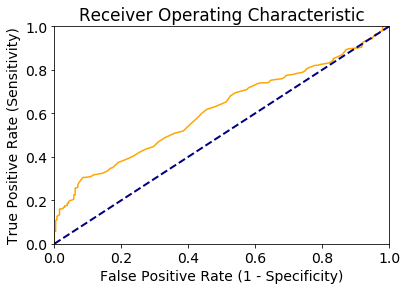

0

In [52]:
store_test_results_classification(rfc_model, "RandomForestClassifier", rfc_best_params)

### Naive Bayes

In [53]:
if rerun_grid_searches:
    nb_params = {
        'alpha' :[1, 0.1, 0.01, 0.001]
    }

    nb_gridsearch = GridSearchCV(MultinomialNB(), nb_params, cv=5, verbose=1, n_jobs=2)
    nb_gridsearch = nb_gridsearch.fit(df_X_tr, y_train)
    nb_model= nb_gridsearch.best_estimator_
    nb_best_params = nb_gridsearch.best_params_
else:
    nb_model=MultinomialNB(alpha=.001)
    nb_best_params = {'alpha': 0.001}

In [54]:
nb_model = nb_model.fit(df_X_tr, y_train)
print(cross_val_score(nb_model, df_X_tr, y_train, cv=5).mean())

0.3998184560038511


Results for NaiveBayes with parameters {'alpha': 0.001}
accuracy for test set 0.3754325259515571


confusion matrix:
 [[ 30  29  44  19  26  64  45]
 [ 21  23  48  56  13  70  31]
 [ 39   3 111  30  28  32  12]
 [  9  10  24 127  47  26  28]
 [  0   2   3  29 147  33   5]
 [  2  17  17  23  12 139  19]
 [  4  17  48  54  21  23  74]]


                 precision    recall  f1-score   support

          books       0.29      0.12      0.17       257
        Fantasy       0.23      0.09      0.13       262
 sciencefiction       0.38      0.44      0.40       255
booksuggestions       0.38      0.47      0.42       271
  whatsthatbook       0.50      0.67      0.57       219
       bookclub       0.36      0.61      0.45       229
          YAlit       0.35      0.31      0.33       241

      micro avg       0.38      0.38      0.38      1734
      macro avg       0.35      0.38      0.35      1734
   weighted avg       0.35      0.38      0.35      1734



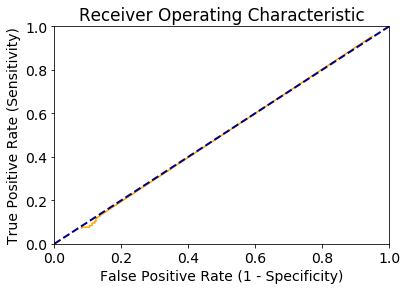

0

In [55]:
store_test_results_classification(nb_model, "NaiveBayes",nb_best_params)

### Support Vector Machine
* this model performed very poorly and takes a very long time to fit, so am commenting it out for performance of the notebook

In [56]:
# if rerun_grid_searches:
#     sdg_params = {
#         'penalty':['l2'],
#         'alpha':[0.0001,.001, 1],
#         'loss':['hinge'],
#         'max_iter': [100]
#     }

#     sdg_gridsearch = GridSearchCV(SGDClassifier(), sdg_params, cv=5, verbose=1, n_jobs=2)

#     sdg_gridsearch = sdg_gridsearch.fit(df_X_tr, y_train)
#     sdg_model= sdg_gridsearch.best_estimator_
#     sdg_best_params = sdg_gridsearch.best_params_
# else:
#     sdg_best_params={'alpha': 1, 'loss': 'hinge', 'max_iter': 100, 'penalty': 'l2'}
#     sdg_model  = SGDClassifier(alpha=1, loss='hinge', max_iter=100, penalty='l2')

In [57]:

# sdg_model = sdg_model.fit(df_X_tr, y_train)
# print(cross_val_score(sdg_model, df_X_tr, y_train, cv=5).mean())

In [58]:
#store_test_results_classification(sdg_model, "SGDClassifier",sdg_best_params)

### Logistic Regression

In [59]:
if rerun_grid_searches:
    lg_params = {
        'penalty':['l2'],
        'C':[.001, 1, 10],
        'solver':['liblinear'],
        'max_iter': [300],
        'multi_class': ['ovr']
    }

    lg_gridsearch = GridSearchCV(LogisticRegression(), lg_params, cv=5, verbose=1, n_jobs=2)

    lg_gridsearch = lg_gridsearch.fit(df_X_tr, y_train)
    lg_model= lg_gridsearch.best_estimator_
    lg_best_params = lg_gridsearch.best_params_
else:
    lg_best_params={'C': 10, 'max_iter': 300, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
    lg_model  = LogisticRegression(C=10, max_iter=300, multi_class='ovr', penalty='l1', solver='liblinear')

In [60]:

lg_model = lg_model.fit(df_X_tr, y_train)
print(cross_val_score(lg_model, df_X_tr, y_train, cv=5).mean())

0.658469469952714


Results for LogisticRegression with parameters {'C': 10, 'max_iter': 300, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
accuracy for test set 0.6487889273356401


confusion matrix:
 [[204  13  20   7   4   0   9]
 [ 19 129  30  42   5   3  34]
 [ 15  27 160  16  16   3  18]
 [ 11  21  16 155  27   7  34]
 [  7   6   9  25 160   5   7]
 [  8   4   2  11   3 194   7]
 [ 12  31  23  36  14   2 123]]


                 precision    recall  f1-score   support

          books       0.74      0.79      0.77       257
        Fantasy       0.56      0.49      0.52       262
 sciencefiction       0.62      0.63      0.62       255
booksuggestions       0.53      0.57      0.55       271
  whatsthatbook       0.70      0.73      0.71       219
       bookclub       0.91      0.85      0.88       229
          YAlit       0.53      0.51      0.52       241

      micro avg       0.65      0.65      0.65      1734
      macro avg       0.65      0.65      0.65      1734
   weighte

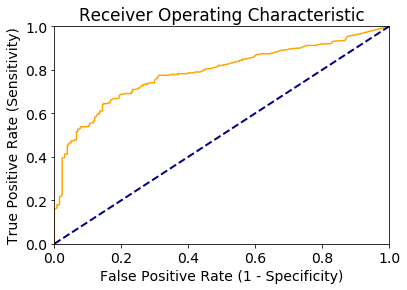

0

In [61]:
store_test_results_classification(lg_model, "LogisticRegression", lg_best_params)

#### Logistic Regression: examine coefficients
* Get the words with the greatest prediction power for each of the subreddits
* create a dataframe of the learned coefficients, sort and then grab the top several for each subreddit

In [115]:
coefs=lg_model.coef_
coef_df=pd.DataFrame({
            'coef': [],
            'feature': [],
            'subreddit': []
        })
for key, subreddit_id in subreddit_mapping.items():
    tmp = pd.DataFrame({
            'coef': coefs[subreddit_id],
            'feature': df_X_tr.columns,
            'subreddit': key
        })
    coef_df=pd.concat([coef_df, tmp], axis=0)

coef_df['abs_coef'] = np.abs(coef_df.coef)
# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df.head()
#coef_df[coef_df.coef> 0][0:10].groupby('subreddit')
coef_df.groupby('subreddit').head(10).sort_values(['subreddit','abs_coef'], ascending=False)

,coef,feature,subreddit,abs_coef
921,-29.289152,title_crosspost,whatsthatbook,29.289152
374,18.693818,title_back,whatsthatbook,18.693818
513,16.833072,title_boy,whatsthatbook,16.833072
3597,-15.465607,title_recommendation,whatsthatbook,15.465607
881,15.284338,title_cover,whatsthatbook,15.284338
2242,14.644622,title_intergalactic,whatsthatbook,14.644622
3416,14.623720,title_pretend,whatsthatbook,14.623720
1467,14.146222,title_fairy,whatsthatbook,14.146222
4919,-13.636635,title_would,whatsthatbook,13.636635
709,12.786277,title_child,whatsthatbook,12.786277


In [63]:
pickle.dump(lg_model, open("logreg_model_" + str(round(time.time(),0)) + ".pkl", "wb"))

### CatBoost

In [64]:
cat_features = []


In [65]:
if rerun_grid_searches:
    model = CatBoostClassifier(
        iterations=500,
        random_seed=63,
        learning_rate=.5,
        custom_loss=['AUC', 'Accuracy'],
        loss_function='MultiClass',
        early_stopping_rounds=50
    )
    model.fit(
        df_X_tr, y_train,
        cat_features=cat_features,
        eval_set=(df_X_tst, y_test),
        verbose=False,
        plot=True
    )
    pickle.dump(model, open("catboost_model_" + str(round(time.time(),0)) + ".pkl", "wb"))
else:
    # load pickled model
    model = pickle.load(open("catboost_model.pkl","rb"))

In [66]:
#model.best_score_['validation_0']

In [67]:
#model.best_iteration_

#### CatBoost: examine most important predictive features

In [68]:
fstrs = model.get_feature_importance(prettified=True)

In [69]:
dict_catboost_features = {feature_name : value for  feature_name, value in fstrs}
dict_catboost_features

{'ups': 20.280868727229645,
 'external_url': 18.822324133648547,
 'num_comments': 13.655831415226766,
 'text_len': 13.573587710359176,
 'title_len': 3.6626098340315836,
 'title_schedule': 2.0363261912873543,
 'title_review': 1.5668708079346747,
 'title_chapter': 1.1753019607841957,
 'title_girl': 1.0746543497211798,
 'title_look': 0.9731603349983914,
 'title_finish': 0.8099198363856228,
 'title_boy': 0.7975755450877389,
 'title_kid': 0.7972512688266398,
 'num_crossposts': 0.7421262083322644,
 'title_fiction': 0.6661867152649502,
 'title_child': 0.5567346881738199,
 'title_young': 0.544208285905498,
 'title_discussion': 0.5425061480236972,
 'title_story': 0.5286274612414434,
 'title_recommendation': 0.4266876392816364,
 'title_suggestion': 0.3922692467344965,
 'title_thread': 0.3760395593875824,
 'title_space': 0.37567496019586544,
 'title_similar': 0.3323135623007257,
 'title_good': 0.309038714249592,
 'title_like': 0.3074453609676415,
 'title_reading': 0.29863328628756686,
 'hour_of_d

Results for CatBoost with parameters 
accuracy for test set 0.6326412918108419


confusion matrix:
 [[154  18  24   9  14  19  19]
 [ 21 120  23  35   8  13  42]
 [ 13  18 156  29  21   7  11]
 [ 17  16  10 174  26   3  25]
 [  1   2   7  20 177   7   5]
 [  9   6   1   6   6 190  11]
 [ 19  17  21  33  16   9 126]]


                 precision    recall  f1-score   support

          books       0.66      0.60      0.63       257
        Fantasy       0.61      0.46      0.52       262
 sciencefiction       0.64      0.61      0.63       255
booksuggestions       0.57      0.64      0.60       271
  whatsthatbook       0.66      0.81      0.73       219
       bookclub       0.77      0.83      0.80       229
          YAlit       0.53      0.52      0.53       241

      micro avg       0.63      0.63      0.63      1734
      macro avg       0.63      0.64      0.63      1734
   weighted avg       0.63      0.63      0.63      1734



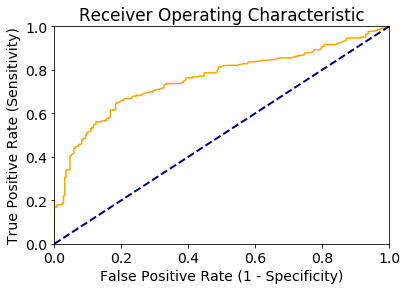

0

In [70]:
store_test_results_classification(model, "CatBoost", "")

### XGBoost

* convert data to optimized DMatrix for XGBoost

In [71]:
#pip install xgboost
import xgboost as xgb

In [72]:
data_dmatrix = xgb.DMatrix(data=df_X_tr,label=y_train)

In [73]:
# note: GridSearchCV wouldn't finish, so am just using basic model for now
xgb_model = xgb.XGBClassifier()
xgb_model.fit(df_X_tr, y_train)
print(xgb_model)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [74]:
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
#        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=True, subsample=1)

Results for XGBoost with parameters 
accuracy for test set 0.5980392156862745


confusion matrix:
 [[144  15  36   5  17  23  17]
 [ 22  91  26  41  14  22  46]
 [ 10  19 149  31  27   8  11]
 [ 14  18   7 170  36   4  22]
 [  1   0   3  18 185   8   4]
 [ 15   7   0  10  10 178   9]
 [ 13  11  29  36  22  10 120]]


                 precision    recall  f1-score   support

          books       0.66      0.56      0.61       257
        Fantasy       0.57      0.35      0.43       262
 sciencefiction       0.60      0.58      0.59       255
booksuggestions       0.55      0.63      0.58       271
  whatsthatbook       0.59      0.84      0.70       219
       bookclub       0.70      0.78      0.74       229
          YAlit       0.52      0.50      0.51       241

      micro avg       0.60      0.60      0.60      1734
      macro avg       0.60      0.61      0.59      1734
   weighted avg       0.60      0.60      0.59      1734



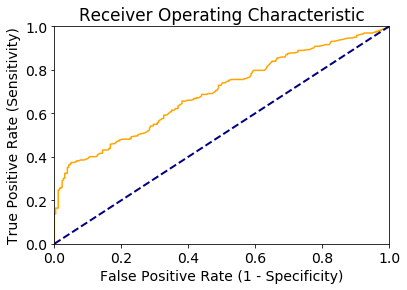

0

In [75]:
store_test_results_classification(xgb_model, "XGBoost", "")

* for some reason, the grid search never finishes for this model so just used simple model above

In [76]:
# # grid search https://wngaw.wordpress.com/2018/01/14/extreme-gradient-boosting-with-xgboost/
# #dmatrix = xgb.DMatrix(data=X_train, label=y_train)
# data_dmatrix
# gbm_param_grid = {
#     'learning_rate': [0.1, 0.05],
#     'max_depth': [3, 4],
#     'n_estimators': [100, 500],
#     'subsample': [0.5, 0.75],
#     'colsample_bytree': [ 0.75],
#     'objective':['multi:softprob'],
#     'booster':['gbtree']
# }
# # XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
# #        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
# #        max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
# #        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
# #        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
# #        silent=True, subsample=1)
 
# gbm = xgb.XGBClassifier()
 
# # Perform grid search
# grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,  cv=5, verbose=1)
# #scoring='roc_auc',
# grid.fit(df_X_tr, y_train) # Using values.ravel() to change to 1D array - https://stackoverflow.com/questions/42928855/gridsearchcv-error-too-many-indices-in-the-array
# # df_X_tr, y_train
# # Print the best parameters &amp; metric
# # print("Best parameters found: ", grid.best_params_)
# # print("Best AUC found: ", grid.best_score_)
 
# # best_learning_rate = grid.best_params_["learning_rate"]
# # best_max_depth = grid.best_params_["max_depth"]
# # best_n_estimators = grid.best_params_["n_estimators"] 
# # best_sub_sample = grid.best_params_["subsample"] 
# # best_colsample_bytree = grid.best_params_["colsample_bytree"] 

#### XGBoost: examine predictive features

In [77]:
xgb_df = pd.DataFrame({
    
    'feature': df_X_tr.columns,
    'importance': xgb_model.feature_importances_
})

In [78]:
xgb_df.sort_values(by='importance', ascending=False, inplace=True)
xgb_df.head(10)

,feature,importance
5000,text_len,0.126011
5002,ups,0.115053
5003,num_comments,0.088442
5001,title_len,0.072528
5006,external_url,0.036264
5005,hour_of_day,0.032090
3072,title_novel,0.013045
1565,title_fiction,0.012784
1634,title_finish,0.010957
3785,title_schedule,0.010175


### Compare the results of our Classifiers

In [79]:
classify_models_df = pd.DataFrame(my_classification_models)
#classify_models_df.sort_values(by='test_f1', ascending=False, inplace=True)
classify_models_df

,features,model,test_accuracy,test_cm,test_f1,test_prec,test_recall,train_accuracy,train_cm,train_f1,train_prec,train_recall
0,"{'criterion': 'entropy', 'max_depth': 20, 'max...",RandomForestClassifier,0.552480,"[[113, 18, 46, 14, 15, 32, 19], [20, 61, 45, 5...","[0.5305164319248826, 0.324468085106383, 0.5545...","[0.6686390532544378, 0.5350877192982456, 0.509...","[0.4396887159533074, 0.23282442748091603, 0.60...",0.659423,"[[419, 9, 115, 32, 43, 53, 42], [61, 277, 111,...","[0.6608832807570978, 0.5158286778398511, 0.612...","[0.7549549549549549, 0.7936962750716332, 0.559...","[0.5876577840112202, 0.3820689655172414, 0.676..."
1,{'alpha': 0.001},NaiveBayes,0.375433,"[[30, 29, 44, 19, 26, 64, 45], [21, 23, 48, 56...","[0.16574585635359115, 0.12672176308539942, 0.4...","[0.2857142857142857, 0.22772277227722773, 0.37...","[0.11673151750972763, 0.08778625954198473, 0.4...",0.437500,"[[95, 73, 129, 62, 56, 184, 114], [82, 93, 101...","[0.1780693533270853, 0.17884615384615385, 0.46...","[0.268361581920904, 0.29523809523809524, 0.434...","[0.1332398316970547, 0.12827586206896552, 0.49..."
2,"{'C': 10, 'max_iter': 300, 'multi_class': 'ovr...",LogisticRegression,0.648789,"[[204, 13, 20, 7, 4, 0, 9], [19, 129, 30, 42, ...","[0.7654784240150093, 0.5233265720081136, 0.621...","[0.7391304347826086, 0.5584415584415584, 0.615...","[0.7937743190661478, 0.49236641221374045, 0.62...",0.974615,"[[704, 2, 1, 2, 0, 0, 4], [7, 690, 5, 17, 0, 1...","[0.9818688981868898, 0.965034965034965, 0.9817...","[0.9764216366158114, 0.9787234042553191, 0.983...","[0.9873772791023843, 0.9517241379310345, 0.979..."
3,,CatBoost,0.632641,"[[154, 18, 24, 9, 14, 19, 19], [21, 120, 23, 3...","[0.6272912423625254, 0.5228758169934641, 0.627...","[0.6581196581196581, 0.6091370558375635, 0.644...","[0.5992217898832685, 0.4580152671755725, 0.611...",0.810769,"[[598, 14, 36, 6, 16, 22, 21], [50, 496, 36, 6...","[0.8311327310632384, 0.7607361963190183, 0.802...","[0.8236914600550964, 0.8566493955094991, 0.829...","[0.8387096774193549, 0.6841379310344827, 0.777..."
4,,XGBoost,0.598039,"[[144, 15, 36, 5, 17, 23, 17], [22, 91, 26, 41...","[0.6050420168067228, 0.4302600472813239, 0.590...","[0.6575342465753424, 0.5652173913043478, 0.596...","[0.5603112840466926, 0.3473282442748092, 0.584...",0.689231,"[[444, 16, 89, 11, 40, 48, 65], [69, 345, 72, ...","[0.6607142857142857, 0.5927835051546392, 0.688...","[0.7036450079239303, 0.785876993166287, 0.6731...","[0.6227208976157083, 0.47586206896551725, 0.70..."


#### NOTES
* best accuracy on the Test Data was achieved by Logistic Regression, followed very closely by Catboost

#### Compare pretty-printed Confusion matrix for Logistic Regression and Catboost

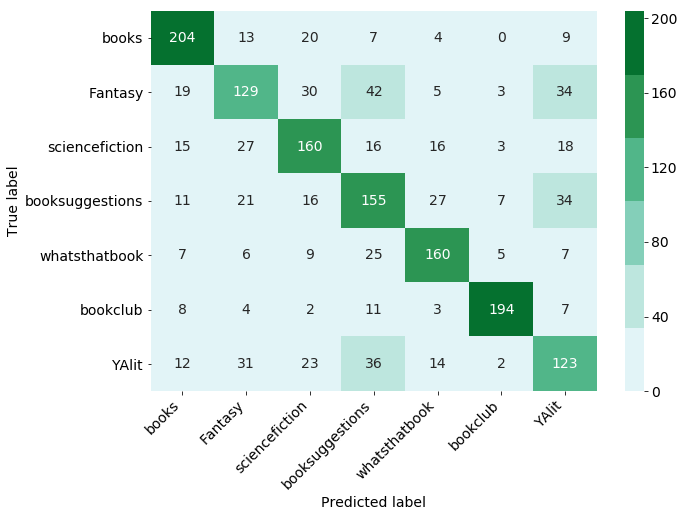

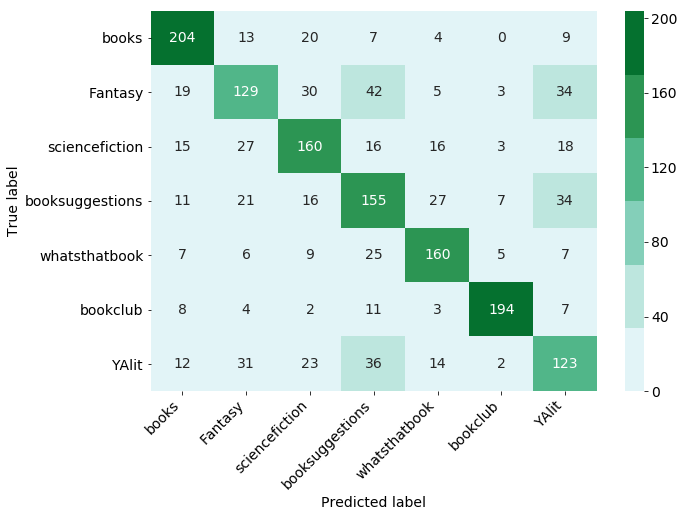

In [80]:
# Logistic Regression
lgpred = lg_model.predict(df_X_tst)
lgcm = confusion_matrix(y_test, lgpred)
print_confusion_matrix(lgcm, URLs)

In [81]:
# CatBoost
cbpred = model.predict(df_X_tst)
cbcm = confusion_matrix(y_test, cbpred)
cbcm

array([[154,  18,  24,   9,  14,  19,  19],
       [ 21, 120,  23,  35,   8,  13,  42],
       [ 13,  18, 156,  29,  21,   7,  11],
       [ 17,  16,  10, 174,  26,   3,  25],
       [  1,   2,   7,  20, 177,   7,   5],
       [  9,   6,   1,   6,   6, 190,  11],
       [ 19,  17,  21,  33,  16,   9, 126]], dtype=int64)

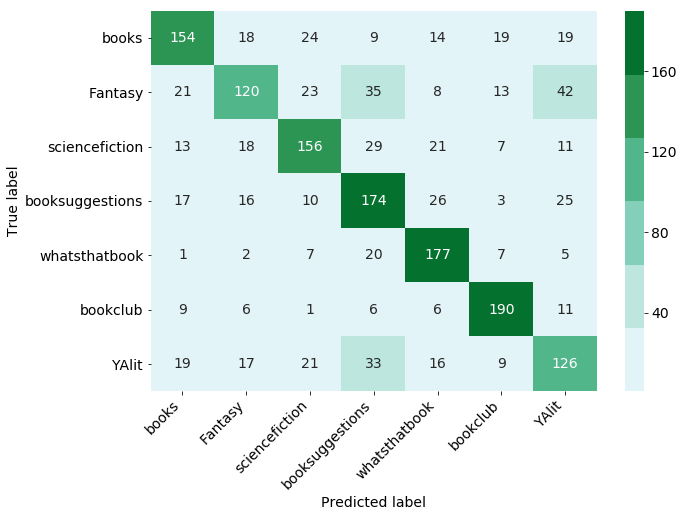

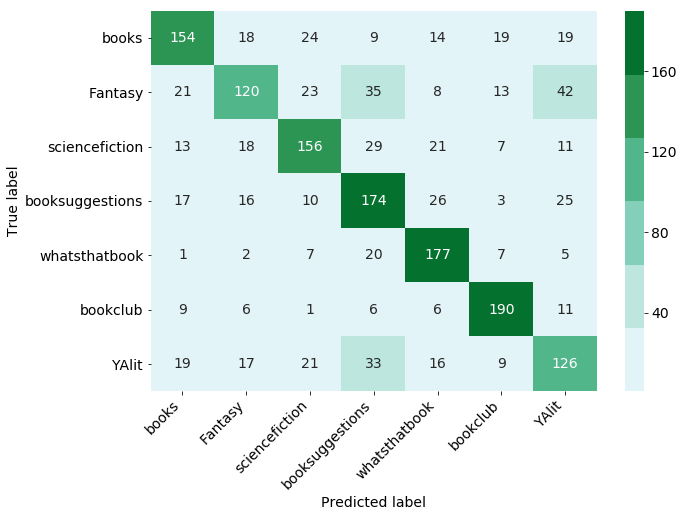

In [82]:
print_confusion_matrix(cbcm, URLs)

* in both models, booksuggestions is often the confusing factor -- not surprising since it crosses many genres

# Let's test our model with some brand new, fresh data from reddit

In [83]:
all_posts = []

for url in URLs:
    new_posts = fetch_subreddit(url, pages=1, only_recent=True)
    new_posts_df=pd.DataFrame(new_posts)


Fetching Page 1
Fetching Page 1
Fetching Page 1
Fetching Page 1
Fetching Page 1
Fetching Page 1
Fetching Page 1


In [84]:
new_posts_df.head()


,author,created_utc,downs,name,num_comments,num_crossposts,selftext,subreddit,title,ups,url
0,brian15co,1.541525e+09,0,t3_9uqabi,0,0,"Usually, the term ""superhuman"" implies some so...",books,"Just finished Robert Caro's ""The Power Broker""...",1,https://www.reddit.com/r/books/comments/9uqabi...
1,porkbelly-endurance,1.541523e+09,0,t3_9upzp7,0,0,,books,Book Review: Entrepreneurs For The Union,1,https://www.wsj.com/amp/articles/civil-war-bar...
2,bibliophile6969,1.541519e+09,0,t3_9upgbk,6,0,"Before I get into this, let me say one thing: ...",books,Can we talk about the Oryx &amp; Crake trilogy?,6,https://www.reddit.com/r/books/comments/9upgbk...
3,CoreySerbia,1.541517e+09,0,t3_9up3xj,2,0,"I never bought used book in English, since I m...",books,Just tried Biblio. What's the deal with cheap ...,1,https://www.reddit.com/r/books/comments/9up3xj...
4,StalePeeps,1.541512e+09,0,t3_9uode8,40,0,Not sure if something like this has been poste...,books,Please reread your high school book lists.,76,https://www.reddit.com/r/books/comments/9uode8...


In [85]:
# convert subreddit_id to an int
new_posts_df['subreddit_id'] = new_posts_df['subreddit'].map(subreddit_mapping).astype(int)
new_posts_df['subreddit_id'].value_counts()

6    10
5    10
4    10
3    10
2    10
1    10
0    10
Name: subreddit_id, dtype: int64

In [86]:
# get our Y test
y_new_test = new_posts_df['subreddit_id']

#### Feed the new data through our two pipelines
*  pipeline 1 removes the subreddit columns and adds the calculated columns
* pipe_title does count vectorization and returns tfidf counts

In [87]:
# pipeline 1 
new_posts_df = pipe_1.transform(new_posts_df)

In [88]:
X_new_test_title_words = pipe_title.transform(new_posts_df['title'])
df_X_new_tst_text = pd.DataFrame(X_new_test_title_words.toarray(), columns=pipe_2.named_steps['cv'].get_feature_names())
## adding a prefix
df_X_new_tst_text = df_X_new_tst_text.add_prefix('Title_')
# combine into datframe
df_X_new_tst_text = pd.concat([df_X_new_tst_text, new_posts_df[numeric_cols].reset_index(drop=True)], axis=1)

In [89]:
df_X_new_tst_text.head()

,Title_abandon,Title_abercrombie,Title_ability,Title_able,Title_able see,Title_absolutely,Title_abusive,Title_academic,Title_accept,Title_access,...,Title_zhivago chapter,Title_zombie,Title_zone,text_len,title_len,ups,num_comments,num_crossposts,hour_of_day,external_url
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1785,109,1,0.0,0,17,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,40,1,0.0,0,16,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1436,47,6,6.0,0,15,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,394,67,1,2.0,0,15,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,489,42,76,40.0,0,13,0


#### Predict the classes and score the model

In [90]:
y_new_prd = lg_model.predict(df_X_new_tst_text)

In [91]:
lg_model.score(df_X_new_tst_text,y_new_test )

0.6285714285714286

In [92]:
print(classification_report(y_new_test, y_new_prd,target_names=URLs))

                 precision    recall  f1-score   support

          books       0.67      0.20      0.31        10
        Fantasy       0.67      0.60      0.63        10
 sciencefiction       0.47      0.70      0.56        10
booksuggestions       0.60      0.90      0.72        10
  whatsthatbook       0.73      0.80      0.76        10
       bookclub       0.80      0.80      0.80        10
          YAlit       0.57      0.40      0.47        10

      micro avg       0.63      0.63      0.63        70
      macro avg       0.64      0.63      0.61        70
   weighted avg       0.64      0.63      0.61        70



* model did ok on sciencefiction (F1 score of .5) and whatsthatbook, but terribly on Fantasy

# Word cloud of top predicting words for each Subreddit

* let's compare the features that were most important for classifying each of the subreddits
* WordCloud can't accept negative values, so use absolute coeefficient (ignore whether a word was a negative/positive predictor and just focus on relative importance)

In [93]:
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [94]:
top_pred_words = coef_df.groupby('subreddit').head(10).sort_values('subreddit')


In [95]:
# remove title from feature
top_pred_words['feature']=top_pred_words['feature'].apply(lambda x: x.replace('title_',''))

In [113]:
freq_dict = top_pred_words[top_pred_words['subreddit']=="Fantasy"].set_index('feature').to_dict()['coef']
freq_dict

{'annoys': -39.88016957188463,
 'baru': 14.576542524067925,
 'abercrombie': 14.915839451558172,
 'expect': 17.063908685545524,
 'love triangle': 17.10879514808352,
 'peasant girl': 17.923614816775206,
 'last week': 19.949082640860063,
 'yargh': 15.084423276740264,
 'trope annoys': -36.48953842964329,
 'one mike': 28.95268927350783}

In [97]:
def show_word_cloud(url, freq_dict=None):
    if freq_dict == None:
        freq_dict = top_pred_words[top_pred_words['subreddit']==url].set_index('feature').to_dict()['abs_coef']
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(freq_dict)
    plt.figure()
    plt.title(url)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

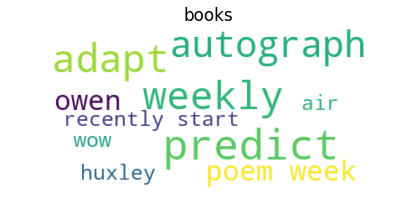

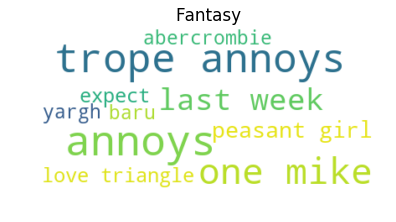

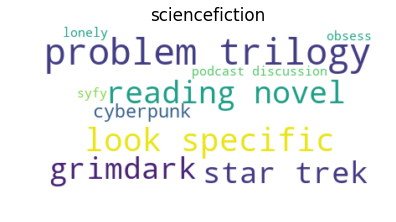

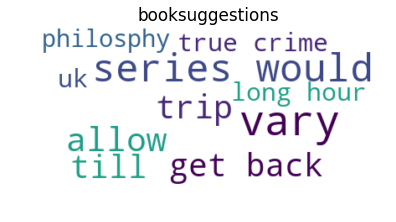

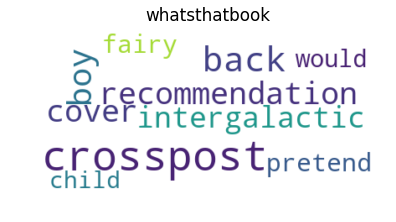

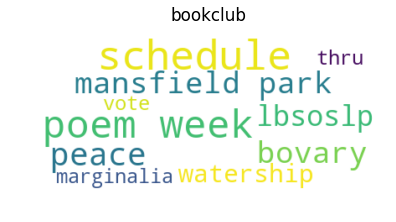

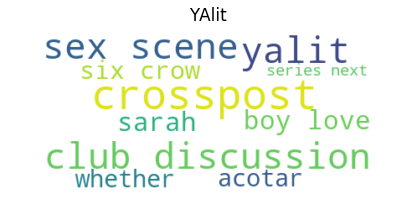

In [98]:
for url in URLs:
    show_word_cloud(url)


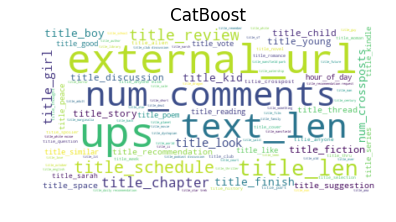

In [99]:
#dict_catboost_features
show_word_cloud("CatBoost", dict_catboost_features)

* wordcloud accepts a dictionary where the key is the word and the value is the number of times it appears
* so we'll convert our dataframe with the top 100 words to a dictionary

# Word2 vec

In [100]:
# import gensim
# from gensim.models import Word2Vec
# import gensim.downloader as api

#word2vec_model300 = api.load('word2vec-google-news-300')


## Try using Doc2Vec to compare similarity of post text

* follow approach from this article: https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4


In [101]:
import gensim
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re



C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [102]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

#### Assign labels (the subreddit id) to each post
* Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
* this can be done with the TaggedDocument method.
* TODO: am using the tokenize text from the post for simplicity, but should be using the 2nd pipeline defined above

In [103]:
if rerun_grid_searches:
    train_tagged =[]
    for i in range(len(X_train)):
        train_tagged.append(TaggedDocument(words=tokenize_text(X_train.iloc[i,:]['selftext']), tags=[y_train.iloc[i]]))

In [104]:
if rerun_grid_searches:
    test_tagged =[]
    for i in range(len(X_test)):
        test_tagged.append(TaggedDocument(words=tokenize_text(X_test.iloc[i,:]['selftext']), tags=[y_test.iloc[i]]))

#### Build the vocabulary

In [105]:
if rerun_grid_searches:
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=2)
    model_dbow.build_vocab([x for x in tqdm(train_tagged)])
else:
    model_dbow = pickle.load(open("doc2vec_model_1541386001.0.pkl","rb"))


#### Train the Doc2Vec model
* train for 30 epochs

In [106]:
if rerun_grid_searches:
    for epoch in range(30):
        model_dbow.train(utils.shuffle([x for x in tqdm(X_train_doc)]), total_examples=len(X_train_doc), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha


In [107]:
if rerun_grid_searches:
    pickle.dump(model_dbow, open("doc2vec_model_" + str(round(time.time(),0)) + ".pkl", "wb"))

In [108]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors


#### Build the vector features (Extremely slow!)

In [109]:
if rerun_grid_searches:
    y_train, X_train = vec_for_learning(model_dbow, train_tagged)
    y_test, X_test = vec_for_learning(model_dbow, test_tagged)
else:
    X_test= pickle.load(open("doc2vec_xtest2_1541391434.0.pkl","rb"))
    y_test=pickle.load(open("doc2vec_ytest2_1541391470.0.pkl","rb"))


#### Train Logistic Regression

In [110]:
if rerun_grid_searches:
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_train, y_train)
    pickle.dump(logreg, open("logreg_doc2vec_" + str(round(time.time(),0)) + ".pkl", "wb"))
else:
    logreg = pickle.load(open("logreg_doc2vec_1541386056.0.pkl","rb"))



In [111]:
logreg

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [112]:
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))


Testing accuracy 0.1972318339100346


# Concluding thoughts

* the best performing model was Logistic Regression, with an accuracy of .64